# Обучение с учителем: качество модели

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 


**Цель проекта**:
Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**План проекта**

 1. Загрузка и обзор данных.
 2. Предобработка данных.
 3. Исследовательский анализ данных.
 4. Объединение таблиц.
 4. Корреляционный анализ.  
 5. Использование пайплайнов.
 6. Анализ важности признаков.
 7. Сегментация покупателей.
 8. Общий вывод.

Установите, пожалуйста, эти версии библиотек, для того, чтобы код не падал с ошибкой. 

In [1]:
pip list

Package                           Version
--------------------------------- -------------------
absl-py                           1.2.0
alembic                           1.6.5
anyio                             3.2.1
argon2-cffi                       20.1.0
astunparse                        1.6.3
async-generator                   1.10
attrs                             21.2.0
Babel                             2.9.1
backcall                          0.2.0
backports.functools-lru-cache     1.6.4
beautifulsoup4                    4.9.3
bleach                            3.3.0
blinker                           1.4
blis                              0.7.8
branca                            0.5.0
brotlipy                          0.7.0
cachetools                        5.2.0
catalogue                         2.0.8
catboost                          1.0.3
certifi                           2022.6.15
certipy                           0.1.3
cffi                              1.14.5
chardet             

In [2]:
#установка версий библиотек 

!pip install -U scikit-learn -q

!pip install matplotlib==3.5.0 -q

!pip install numpy==1.20.1 -q
   
!pip install shap -q

!pip install phik -q

In [3]:
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns

import phik
from phik.report import plot_correlation_matrix


import numpy as np
from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    LabelEncoder, 
    StandardScaler, 
    MinMaxScaler
)

from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import shap

## Загрузка данных

In [4]:
#создадим функцию для вывода общей информации о датасете
def main_info(df):
    display(df.head(10))
    df.info()

In [5]:
#считаем данные и загрузим в соответствующие датафреймы
market_data = pd.read_csv('market_file.csv', sep=',')
market_money_data = pd.read_csv('market_money.csv', sep=',')
market_time_data = pd.read_csv('market_time.csv', sep=',')
money_data = pd.read_csv('money.csv', sep=';', decimal=',')

In [6]:
#выведем общую информацию о первом датасете
main_info(market_data)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Видим, что в данных нет пропусков, типы данных соответствуют ожидаемым

In [7]:
#выведем общую информацию о датасете с данными о выручке, которую получает магазин с покупателя
main_info(market_money_data)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Видим, что в данных нет пропусков, типы данных соответствуют ожидаемым

In [8]:
#выведем общую информацию о датасете с данными о времени (в минутах), 
#которое покупатель провёл на сайте в течение периода.
main_info(market_time_data)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Так же видим, что в данных нет пропусков, типы данных соответствуют ожидаемым

In [9]:
#выведем общую информацию о датасете с данными о среднемесячной прибыли покупателя за последние 3 месяца
main_info(money_data)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Тот же результат - в данных нет пропусков, типы данных соответствуют ожидаемым

### Вывод
Провели загрузку и обзор данных, в данных нет пропусков и типы данных соответствуют ожидаемым. 

## Предобработка данных

### Датасет market_data

In [10]:
#выведем все уникальные значения в столбцах датасета
market_data.select_dtypes(exclude='number').apply(lambda x: x.unique())

Покупательская активность                         [Снизилась, Прежний уровень]
Тип сервиса                                     [премиум, стандартт, стандарт]
Разрешить сообщать                                                   [да, нет]
Популярная_категория         [Товары для детей, Домашний текстиль, Косметик...
dtype: object

Видим неявные дубликаты в столбце со значениями типа сервиса, также названия столбцов не соответствуют правильным. 

In [11]:
#изменим наименования столбцов
market_data.columns = market_data.columns.str.replace(' ', '_', regex=True)
market_data.columns = market_data.columns.str.lower()

#проверим изменения
market_data.head()


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [12]:
#заменим ошибки в категории "тип сервиса"
market_data['тип_сервиса'] = market_data['тип_сервиса'].replace('стандартт', 'стандарт')

In [13]:
#проверим на наличие ошибок популярные категории
market_data['популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [14]:
#проверим датасет на наличие явных дубликатов
market_data.duplicated().sum()

0

Провели обзор данных датасета market_data, заменили неявные дубликаты, изменили названия стобцов на верные  

### Датасет market_money_data

In [15]:
#проверим на ошибки категорию "период"
market_money_data['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [16]:
#проверим датасет на наличие явных дубликатов
market_money_data.duplicated().sum()

0

In [17]:
#изменим названия столбцов
market_money_data.columns = market_money_data.columns.str.lower()

Провели обзор данных датасета market_money_data, не найдены ошибки или дубликаты

### Датасет market_time_data

In [18]:
#проверим на ошибки категорию "период"
market_time_data['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [19]:
#заменим ошибки в названиях периодов
market_time_data['Период'] = market_time_data['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

In [20]:
#проверим датасет на наличие явных дубликатов
market_time_data.duplicated().sum()

0

In [21]:
market_time_data.columns = market_time_data.columns.str.lower()

Провели обзор данных датасета market_time_data, заменили ошибки в столбце "период", явные дубликаты не найдены

### Датасет money_data

In [22]:
#проверим датасет на наличие явных дубликатов
money_data.duplicated().sum()

0

In [23]:
#приведем названия столбцов к нижнему регистру
money_data.columns = money_data.columns.str.lower()

Провели обзор данных датасета money_data, дубликаты не найдены

### Вывод
Произвели обзор данных четырех датасетов, привели наименования столбцов к единому регистру, заменили ошибки в значениях столбцов и проверили наличие дубликатов. 

## Исследовательский анализ данных

Необходимо провести исследовательский анализ данных из каждой таблицы. Также отобрать клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. 

### Анализ датасета market_data

In [24]:
#выведем общее описание количественных признаков
market_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


Не видим аномальных значений или выбросов

In [25]:
#сделаем замену индексов как значения id
market_data = market_data.set_index('id')

In [26]:
#создадим список значений количественных признаков
num_col_names_1 = market_data.select_dtypes(include='number').columns.tolist()

labels_num_1 = ['Ср.месячное значение маркетинговых активностей за посл. 6 месяцев',
        'Количество маркетинговых активностей в текущем месяце', 
        'Дней с момента регистрации', 
        'Ср.месячная доля покупок по акции от общего числа покупок за посл. 6 месяцев',
        'Среднее количество категорий за визит в течение последнего месяца',
        'Количество неоплаченных продуктов', 
        'Число сбоев за визит',
        'Среднее кол-во страниц за один визит на сайт за последние 3 месяца'
               ]

In [27]:
#создадим функцию для построения графиков распределения количественных признаков
def graph_maker_num(df, col_names, labels):
    for i, col_name in enumerate(col_names):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        df[col_name].plot(kind='hist', bins=10, ax=axes[0])
        axes[0].set_title(f'Гистограмма распределения, {col_name}')
        axes[0].set_xlabel(f'{labels[i]}')
        axes[0].set_ylabel('Количество покупателей')
        df[col_name].plot(kind='box', ax=axes[1], vert=False)
        axes[1].set_title(f'Разброс значений признаков, {col_name}')
        axes[1].set_xlabel(f'{labels[i]}')
        axes[1].set_yticks([])
        plt.show()

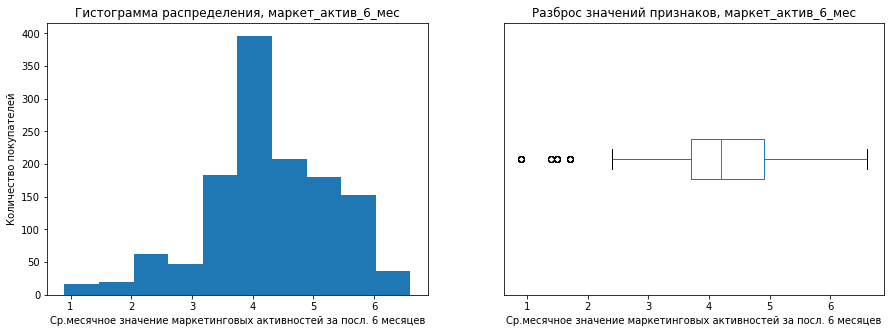

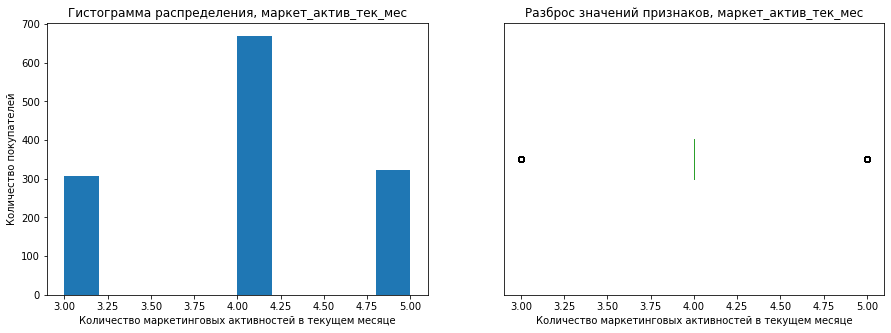

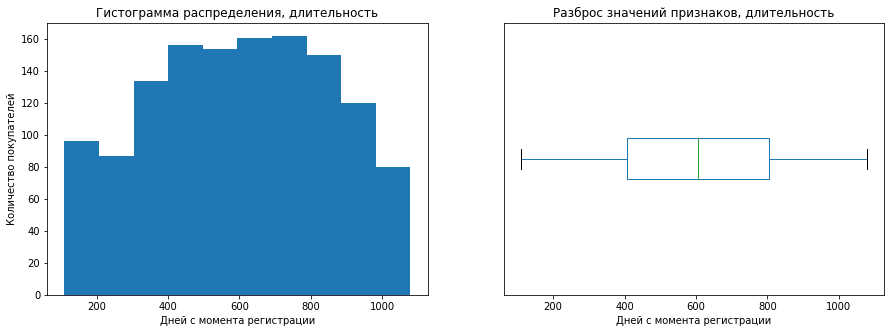

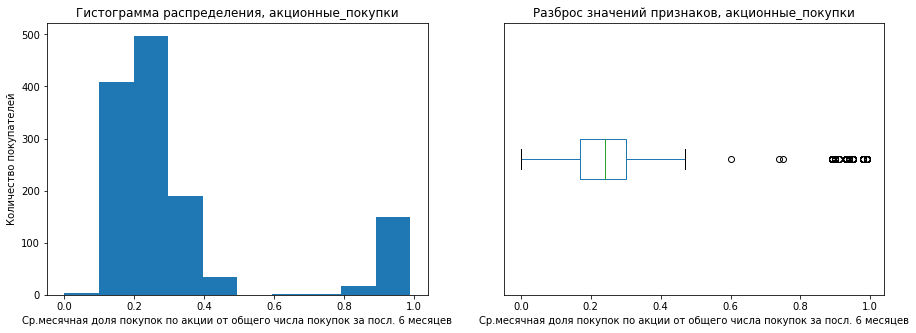

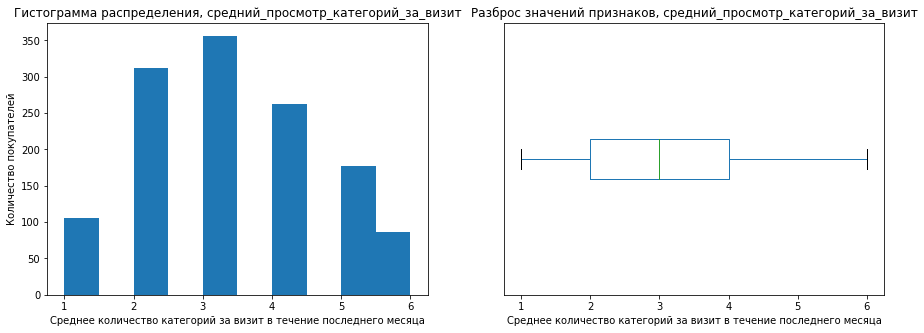

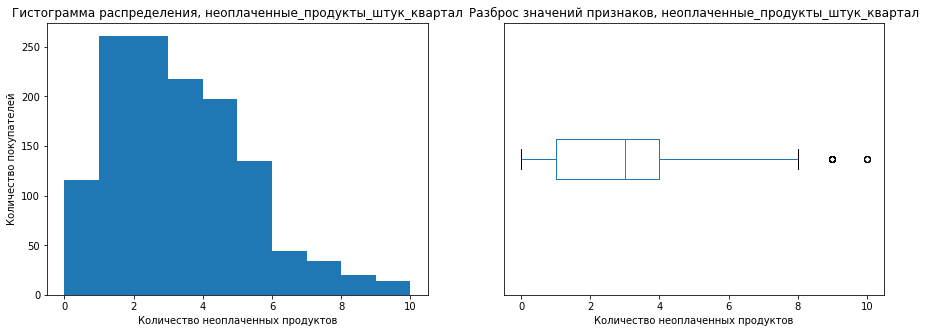

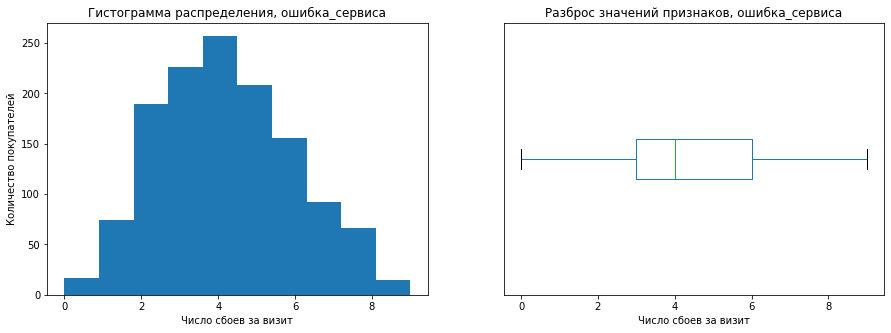

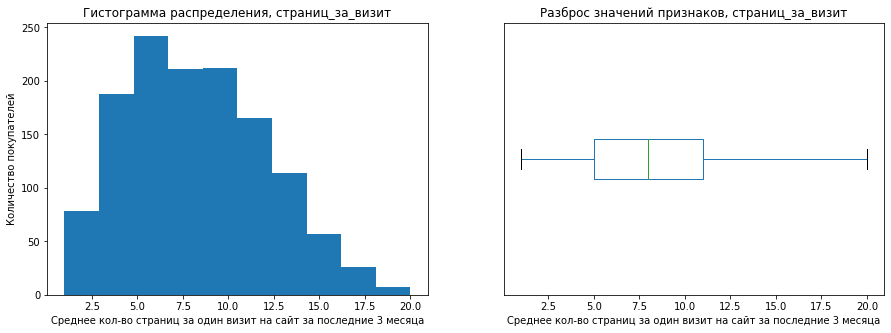

In [28]:
#построим графики распределения количественных признаков
graph_maker_num(market_data, num_col_names_1, labels_num_1)

На графиках можно отметить следующее: графики распределения маркетинговых активностей за последние полгода, в текущем месяце, средних просмотров за визит и ошибок сервиса - похожи на нормальные. 

Графики распределения неоплаченных продуктов и страниц за визит - нормальные, но со смещением вправо. 

По графику распределения длительности можно увидеть, что в выборке взят срез покупателей с длительностью пользования от 110 дней.

По графику распределения акционных покупок - видим выбросы со среднемесячной долей покупок по акции более 60 процентов от общего количества совершенных покупок, за последние полгода. Это покупатели, интересующиеся только товарами по акции. 

Рассмотрим самую популярную категорию у покупателей товаров преимущественно только по акции

In [29]:
market_data[market_data['акционные_покупки'] > 0.6]['популярная_категория'].value_counts()

Товары для детей                        49
Косметика и аксесуары                   29
Домашний текстиль                       28
Техника для красоты и здоровья          25
Кухонная посуда                         22
Мелкая бытовая техника и электроника    14
Name: популярная_категория, dtype: int64

Самая популярная категория здесь - товары для детей, то есть вероятно покупатели приобретают эти товары по акции, далее после того как дети взрослеют - эти товары больше не нужны и покупатель больше не пользуется сайтом для покупок. 

In [30]:
#создадим список качественных признаков
cat_col_names_1 = market_data.select_dtypes(exclude='number').columns.tolist()

In [31]:
#создадим функцию построения графиков распределения качественных признаков
def cat_graph_maker(df, col_names):
    i = 1
    fig, ax = plt.subplots()
    for col_name in col_names:
        ax = plt.subplot(3, 3, i)
        df[col_name].value_counts().plot(kind='pie', autopct='%.1f%%', ax=ax, figsize=(16, 14))
        i +=1
        ax.set_title(f'Диаграмма распределения, {col_name}')
        ax.set_ylabel('')
    fig.tight_layout()  
    plt.show() 
        

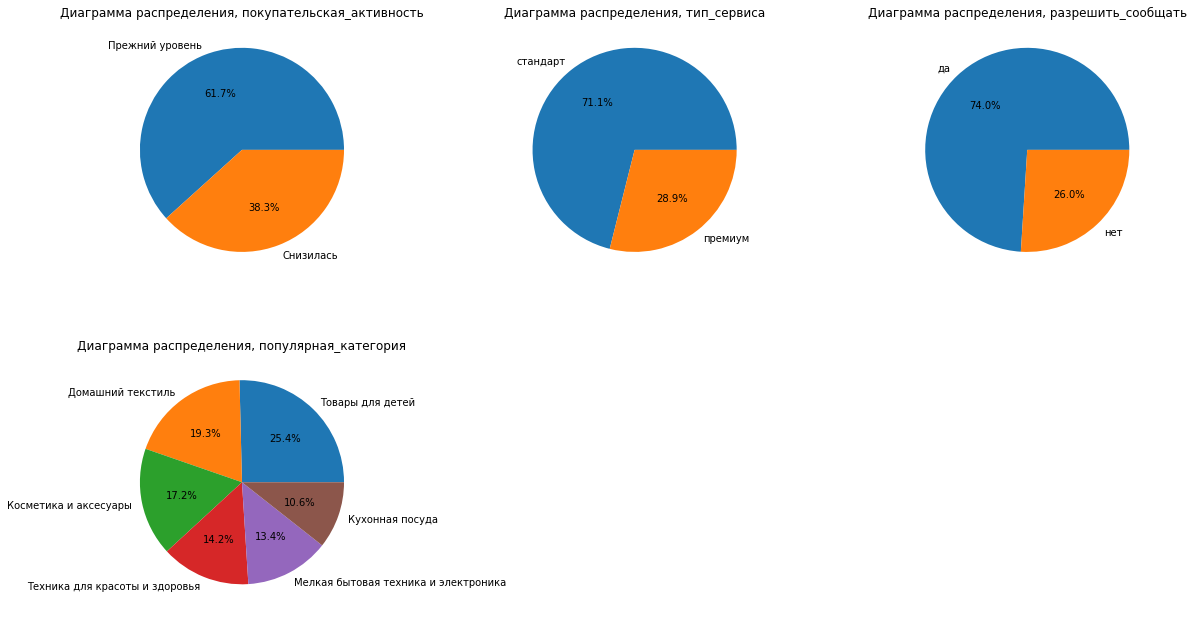

In [32]:
#построим графики распределения качественных признаков
cat_graph_maker(market_data, cat_col_names_1)

Можно отметить небольшой дисбаланс признаков - покупательская активность (преобладает класс с прежним уровнем активности), тип сервиса (преобладает класс с сервисом стандарт) и разрешение на сообщения о дополнительных предложениях (преобладает класс, разрешающий сообщения)

По популярным категориям товаров: самая популярная категория - товары для детей, менее популярная - кухонная посуда. Категории распределены достаточно равномерно. 

### Анализ датасета market_time_data

In [33]:
#выведем общее описание количественных признаков
market_time_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0


In [34]:
#сделаем замену индексов как значения id
market_time_data = market_time_data.set_index('id')

In [35]:
#создадим список 
num_col_names_2 = ['минут']

labels_num_2 = ['значение времени, проведённого на сайте, в минутах']

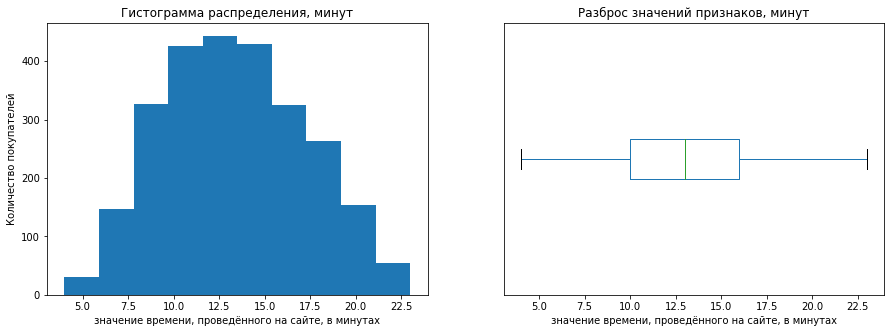

In [36]:
#построим график распределения количественных признаков
graph_maker_num(market_time_data, num_col_names_2, labels_num_2)

Распределение времени, проведенного покупателями на сайте нормальное, выбросов не замечено

In [37]:
#создадим список качественных признаков
cat_col_names_2 = ['период']

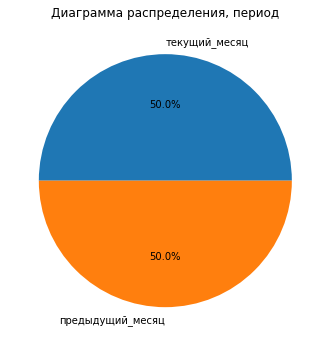

In [38]:
#построим график распределения качественных признакови
cat_graph_maker(market_time_data, cat_col_names_2)

По диаграмме можно сделать вывод, что в признаке "период" нет дисбаланса классов признаков.  

### Анализ датасета market_money_data

In [39]:
#выведем общее описание количественных признаков
market_money_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2


In [40]:
#сделаем замену индексов как значения id
market_money_data = market_money_data.set_index('id')

In [41]:
#создадим список количественных признаков 
num_col_names_3 = ['выручка']

labels_num_3 = ['сумма выручки за период']

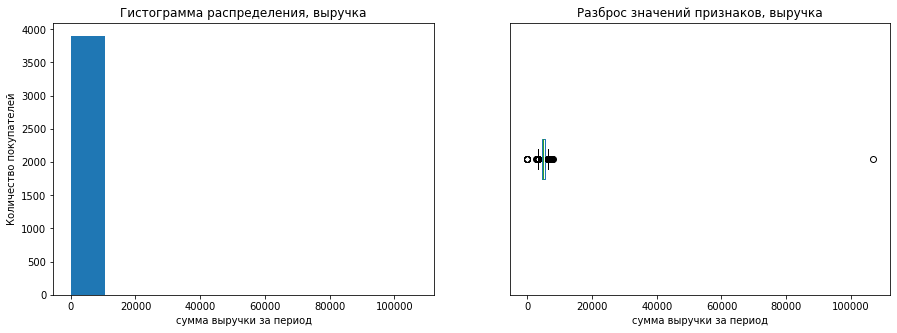

In [42]:
#построим график распределения количественных признаков
graph_maker_num(market_money_data, num_col_names_3, labels_num_3)

Можно увидеть выброс данных, максимальное значение выручку за определенный период - 106862.2

Рассмотрим этот выброс подробнее

In [43]:
market_money_data[market_money_data['выручка'] > 20000]

,период,выручка
id,,
215380,текущий_месяц,106862.2


Не вижу способа определить, какие данные были истинными (это может быть выручка за все периоды в сумме или же ошибка с количеством цифр до запятой), поэтому этот выброс нужно удалить. 

In [44]:
market_money_data = market_money_data.query('выручка <20000')

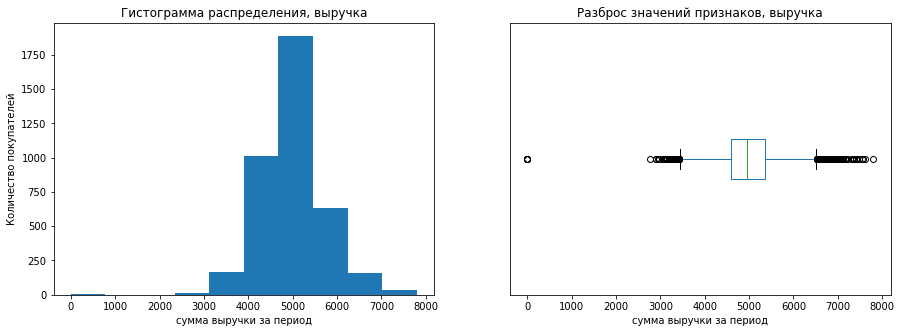

In [45]:
#построим график снова
graph_maker_num(market_money_data, num_col_names_3, labels_num_3)

Теперь можно увидеть выброс даныных - нулевое значение выручки за определенный период, рассмотрим его подробнее

In [46]:
market_money_data.query('выручка == 0')

,период,выручка
id,,
215348,препредыдущий_месяц,0.0
215348,предыдущий_месяц,0.0
215357,препредыдущий_месяц,0.0
215357,предыдущий_месяц,0.0
215359,предыдущий_месяц,0.0
215359,препредыдущий_месяц,0.0


Покупатели с нулевой выручкой в предыдущий и предпредыдущий месяц - это покупатели с активностью только в текущем месяце (то есть менее чем три месяца). В соответствии с заданием, уберем их из последующего анализа. 

In [47]:
id_list = market_money_data.query('выручка == 0').index.unique()
id_list

Int64Index([215348, 215357, 215359], dtype='int64', name='id')

In [48]:
market_money_data = market_money_data.query('index not in @id_list')

Проверим изменения

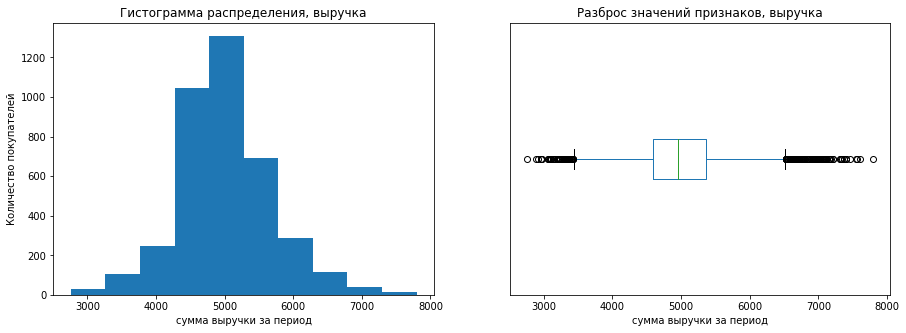

In [49]:
graph_maker_num(market_money_data, num_col_names_3, labels_num_3)

Распределение выручки - нормальное

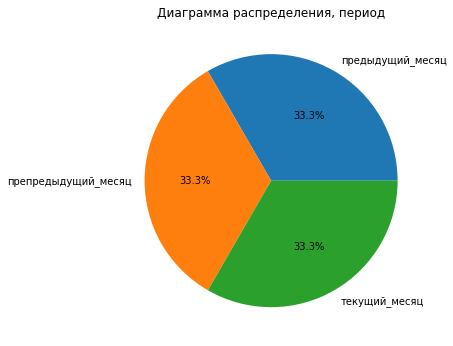

In [50]:
#построим график распределения качественных признаков
cat_graph_maker(market_money_data, cat_col_names_2)

Можно отметить сбалансированное распределение признака "период", данные распределены поровну между тремя периодами

### Анализ датасета money_data

In [51]:
#выведем общее описание количественных признаков
money_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.00,215672.75,215997.500,216322.25,216647.00
прибыль,1300.0,3.996631,1.013722,0.86,3.30,4.045,4.67,7.43


In [52]:
#сделаем замену индексов как значения id
money_data = money_data.set_index('id')

In [53]:
#создадим список количественных признаков
num_col_names_4 = ['прибыль']

labels_num_4 = ['ср.месячная прибыль покупателя за последние 3 месяца']

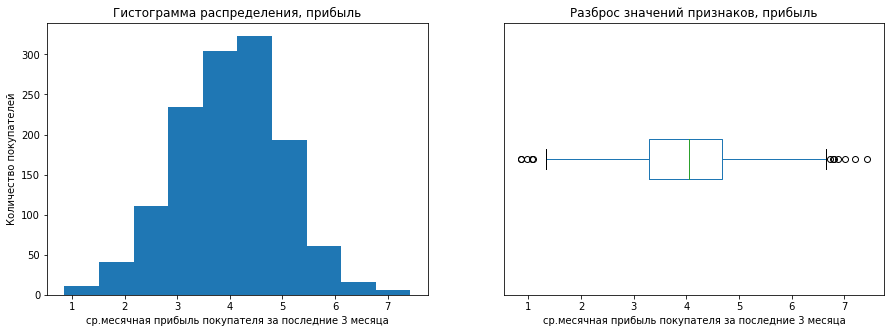

In [54]:
#построим график распределения количественных признаков
graph_maker_num(money_data, num_col_names_4, labels_num_4)

Распределение прибыли - нормальное, выбросов не наблюдаем

### Вывод
Провели исследовательский анализ данных четырех таблиц. Распределения признаков в целом нормальные. 

Можно отметить небольшой дисбаланс признаков - покупательская активность (преобладает класс с прежним уровнем активности), тип сервиса (преобладает класс с сервисом стандарт) и разрешение на сообщения о дополнительных предложениях (преобладает класс, разрешающий сообщения)

Были отобраны клиенты с покупательской активностью не менее трех месяцев. 

## Объединение таблиц

Объедините таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании вам не понадобятся. 

Учитывайте, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделайте отдельный столбец для каждого периода.

In [55]:
#создадим отдельные столбцы для каждого периода по выручке
market_money_data = market_money_data.pivot_table(
    index='id', 
    columns='период', 
    values='выручка', 
    aggfunc='first').rename(
    columns =
    {
        'предыдущий_месяц': 'выручка_предыдущий_месяц', 
        'препредыдущий_месяц': 'выручка_препредыдущий_месяц', 
        'текущий_месяц': 'выручка_текущий_месяц'
    }
)

In [56]:
#проверим данные на наличие пропусков
market_money_data[market_money_data['выручка_текущий_месяц'].isna()]

период,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,
215380,6077.0,5051.0,NaN


Видим, что для выручки в текущем месяца для пользователя 215380 нет данных, поэтому заменим пропуск на нулевое значение

In [57]:
market_money_data = market_money_data.dropna(axis=0)

In [58]:
#выведем измененный датасет
market_money_data.head(10)

период,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5
215354,5685.0,4503.0,5869.6
215355,3263.0,4749.0,3772.6
215356,4146.5,4433.0,4566.4
215358,3488.0,4727.0,4209.5


In [59]:
#создадим отдельные столбцы для каждого периода по времени на сайте
market_time_data = market_time_data.pivot_table(
    index='id', 
    columns='период', 
    values='минут', 
    aggfunc='first').rename(
    columns =
    {
        'предыдущий_месяц': 'время_предыдущий_месяц', 
        'текущий_месяц': 'время_текущий_месяц'
    }
)

In [60]:
#выведем измененный датасет
market_time_data.head(10)

период,время_предыдущий_месяц,время_текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11
215353,10,10
215354,11,12
215355,12,10
215356,6,7


In [61]:
#объеденим датасеты 
market_full = market_data.join(market_money_data, on='id', how='inner')

In [62]:
#объеденим датасеты 
market_full = market_full.join(market_time_data, on='id', how='inner')

In [63]:
#проверим изменения
market_full.head(10)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,5685.0,4503.0,5869.6,11,12
215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,3263.0,4749.0,3772.6,12,10
215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4146.5,4433.0,4566.4,6,7
215358,Снизилась,стандарт,да,4.7,4,450,0.13,Домашний текстиль,4,2,6,4,3488.0,4727.0,4209.5,14,10


In [64]:
#проверим данные на наличие дубликатов
market_full.reset_index().duplicated().sum()

0

In [65]:
#проверим данные на наличие пропусков
market_full.isna().sum()

покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_предыдущий_месяц               0
выручка_препредыдущий_месяц            0
выручка_текущий_месяц                  0
время_предыдущий_месяц                 0
время_текущий_месяц                    0
dtype: int64

### Вывод
Произвели объединение таблиц.

## Корреляционный анализ

Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

In [66]:
#подготовим список признаков
interval_cols = market_full.select_dtypes(include='float64').columns.tolist()

In [67]:
#проведем расчет корреляции между признаками
phik_overview = market_full.phik_matrix(interval_cols=interval_cols)

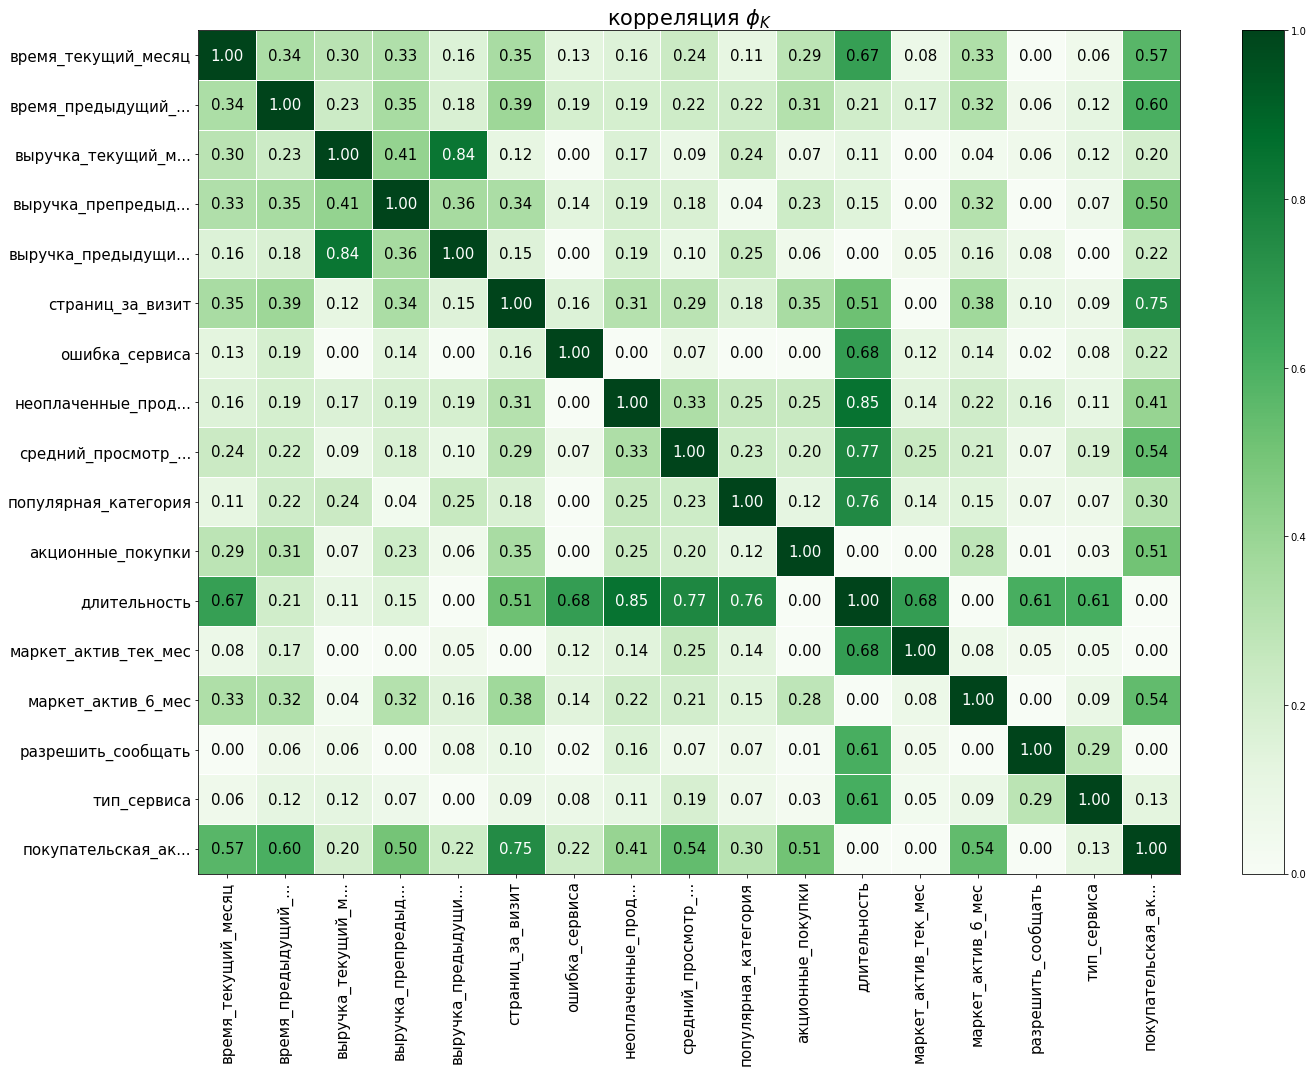

In [68]:
#построим визуализацию матрицы корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels = phik_overview.columns,
    y_labels = phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20,15)
    
)

Можно отметить наличие высокой связи между признаками выручки в разные периоды, между длительностью регистрации покупателя и количеством неоплаченных продуктов, средним просмотром категорий и популярными категориями. 

Высокая связь между покупательской активностью и средним количеством страниц за визит. 

Заметная связь между длительностью и ошибками сервиса, просмотром страниц за визит, маркетинговой активностью за полгода, разрешением сообщать об предложениях и типом сервиса. 

Заметная связь между покупательской активностью и временем в текущем и предыдущем месяцах, средним просмотром категорий, акционными покупками и маркетинговой активностью за полгода. 

При этом можно отметить очень слабую связь или ее практически отсутствие между целевым признаком покупательской активности и длительностью регистрации, маркетинговыми активностями в текущем месяце, разрешением на оповещения с предложениями, выручкой в последние два месяца, ошибками сервиса, популярной категорией товаров. 

Можно сказать, что между признаками нет мультиколлинеарности. 

## Использование пайплайнов

Примените все изученные модели. Для этого используйте пайплайны.


Во время подготовки данных используйте ColumnTransformer. Количественные и категориальные признаки обработайте в пайплайне раздельно. Для кодирования категориальных признаков используйте как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.
Напоминаем, что для каждой модели можно подготовить данные с разным кодированием и масштабированием.

Обучите четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них подберите как минимум один гиперпараметр. Выберите подходящую для задачи метрику, аргументируйте свой выбор. Используйте эту метрику при подборе гиперпараметров.

Выберите лучшую модель, используя заданную метрику. Для этого примените одну из стратегий:
использовать пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно;
использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт вам лучшую модель.

In [69]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

encoder = LabelEncoder()

X = market_full.drop(['покупательская_активность'], axis=1)
y = encoder.fit_transform(market_full['покупательская_активность'])

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y
)

In [70]:
#создаём списки с названиями признаков
ohe_columns = ['популярная_категория', 'разрешить_сообщать']
ord_columns = ['тип_сервиса']
num_columns = [
    'время_текущий_месяц', 
    'время_предыдущий_месяц', 
    'выручка_предыдущий_месяц', 
    'выручка_препредыдущий_месяц', 
    'выручка_текущий_месяц',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'страниц_за_визит',
    'маркет_актив_6_мес',
    'маркет_актив_тек_мес',
    'длительность',
    'акционные_покупки'
]

In [71]:
#создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
#SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
    ]
    )

In [72]:
#создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
#SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['премиум', 'стандарт']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [73]:
#создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [74]:
#создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [75]:
param_grid = [
    #словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    #словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    #словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
     #словарь для модели SV()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel = 'rbf', probability=True)],
        'models__C': [0.01,0.1,1,2,5,10],
        'models__gamma': [0.01,0.1,1,2,5,10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Так как при анализе данных заметили небольшой дисбаланс классов, то будем использовать метрику ROC-AUC для оценки качества модели. 

Будем использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт лучшую модель.

In [76]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория',
                                                   'разрешить_сообщать']),
                                                 ('ord',
                                 

In [77]:
#проверим работу модели на тестовой выборке
#y_test_pred = randomized_search.predict(X_test)
probabilities = randomized_search.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print(f'Площадь ROC-кривой на тестовой выборке: {roc_auc_score(y_test, probabilities_one)}')

Площадь ROC-кривой на тестовой выборке: 0.911175828176192


Получили на выходе лучшую модель - SVC, со значением метрики ROC-AUC на тренировочной и тестовой выборке 0.91 

### Вывод
Использовали один общий пайплайн для всех моделей, использовали инструмент RandomizedSearchCV для подбора гиперпараметров. 
Получили лучшую модель - SVC со со значением метрики ROC-AUC на тренировочной и тестовой выборке равной 0.91

## Анализ важности признаков



Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP. 

Сделайте выводы о значимости признаков:
какие признаки мало значимы для модели;
какие признаки сильнее всего влияют на целевой признак;
как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.

### Построение графиков важности признаков методом SHAP

In [78]:
#подготовим наименования признаков для интерпретации прогнозов модели
ohe_features = (
    randomized_search.best_estimator_['preprocessor']
    .named_transformers_['ohe']
    .get_feature_names_out()
)

In [79]:
#сформируем список признаков
columns = np.concatenate([ohe_features, ord_columns, num_columns])

In [80]:
#подготовим данные для интерпретации
X_train_coded = randomized_search.best_estimator_['preprocessor'].transform(X_train)

In [81]:
#кодируем признаки 
X_test_coded = randomized_search.best_estimator_['preprocessor'].transform(X_test)

In [82]:
#выбираем лучшую модель
model = randomized_search.best_estimator_['models']

In [83]:
#подготовим данные для интерпретации
masker = shap.maskers.Independent(X_train_coded, max_samples=10)

In [84]:
#запускаем алгоритм 
explainer = shap.Explainer(model.predict, masker, feature_names = columns)

In [85]:
shap_values = explainer(X_test_coded)

PermutationExplainer explainer: 325it [00:41,  6.62it/s]                         


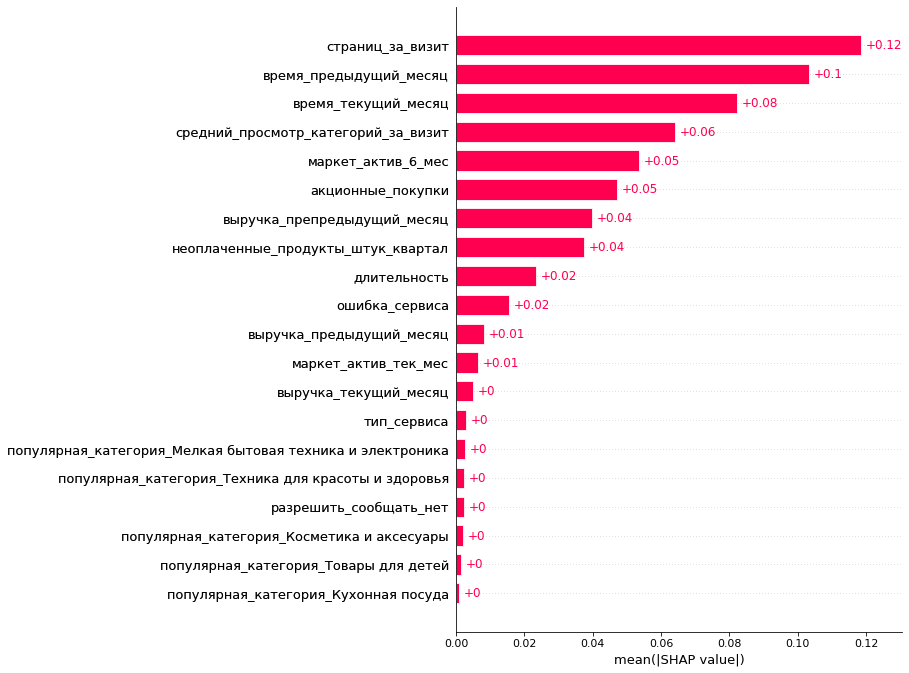

In [86]:
#построим график общей значимости признаков
shap.plots.bar(shap_values, max_display=20) 

По графику видим, что самыми значимыми признаками являются: время в предыдущем и текущем месяце, средний просмотр категорий за визит, страниц за визит, маркетинговые активности за последние полгода и акционные покупки.
Чуть менее важными -  выручка за препредыдущий месяц и неоплаченные продукты в штуках за квартал. 

В то же время, такие признаки как тип сервиса, какую категорию чаще выбирает покупатель или разрешение на сообщения о предложениях мало значимы для модели.  

Построим график влияния признаков на каждое предсказание

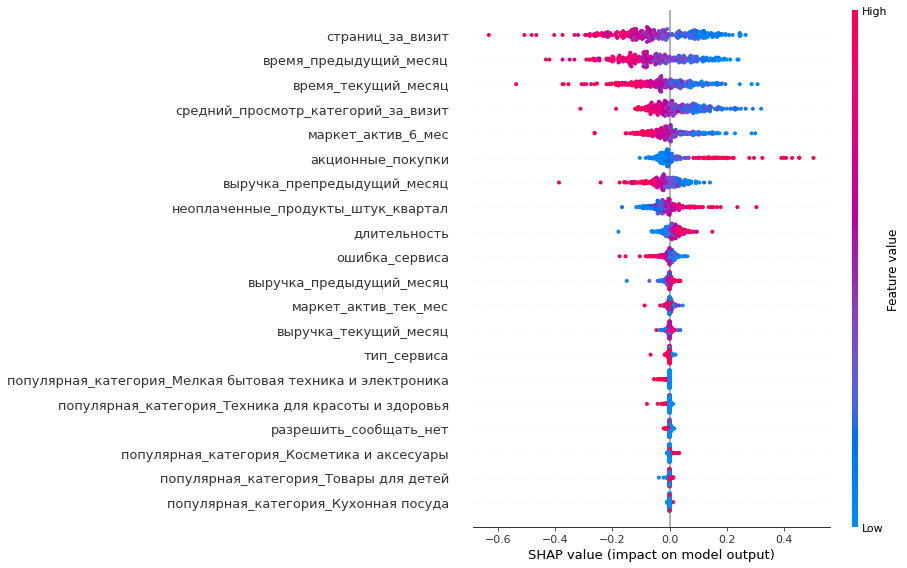

In [87]:
shap.plots.beeswarm(shap_values, max_display=20)

Можно отметить следующее:
1. Чем больше времени провел покупатель на сайте в текущем и предыдущем месяце, тем меньше вероятность отнесения покупателя к классу 1 (снижение покупательской активности)
2. Чем больше страниц покупатель просматривает за визит, тем меньше вероятность отнесения покупателя к классу 1 
3. Чем больше среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев, тем меньше вероятность отнесения покупателя к классу 1 
4. Чем больше значение среднемесячной доли покупок по акции от общего числа покупок за последние 6 месяцев, тем выше риск снижения покупательской активности. 
5. Чем больше число неоплаченных товаров за последние три месяца, тем выше риск снижения покупательской активности. 

Рассмотрим более подробно, влияние признаков на каждое предсказание

In [88]:
#подготовим датасет 
X_test_df = pd.DataFrame(X_test, columns = columns).reset_index()
X_test_df['y_test'] = y_test.tolist()
X_test_df['predict_proba'] = model.predict_proba(X_test_coded)[:,1]

In [89]:
#отберем важные признаки
features = ['страниц_за_визит', 
            'время_текущий_месяц', 
            'время_предыдущий_месяц', 
            'выручка_препредыдущий_месяц', 
            'средний_просмотр_категорий_за_визит',
            'неоплаченные_продукты_штук_квартал',
            'ошибка_сервиса',
            'маркет_актив_6_мес',
            'длительность',
            'акционные_покупки'
]

In [90]:
#выведем данные, в которых модель не смогла предсказать снижение активности
X_test_df[(X_test_df['y_test']==1)&(X_test_df['predict_proba']<0.3)][features]

,страниц_за_визит,время_текущий_месяц,время_предыдущий_месяц,выручка_препредыдущий_месяц,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,маркет_актив_6_мес,длительность,акционные_покупки
24,15,11,14,4779.0,3,3,4,6.6,839,0.24
27,17,13,15,4439.0,2,1,4,5.2,591,0.18
77,11,20,11,5154.0,4,3,4,3.4,698,0.16
83,10,10,16,4663.0,3,0,6,4.4,417,0.23
111,9,19,14,5204.0,6,2,7,4.8,410,0.17
136,11,16,17,4538.0,2,3,9,4.6,993,0.24
141,13,14,11,4853.0,1,0,4,3.8,724,0.26
152,4,17,17,4940.0,2,3,2,4.3,384,0.21
167,13,16,12,4691.0,4,2,3,4.1,808,0.15
184,10,15,17,5053.0,3,3,4,4.3,951,0.20


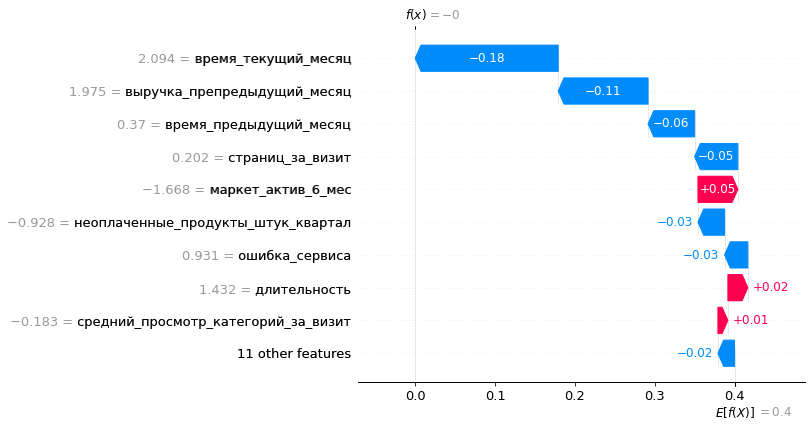

In [91]:
shap.plots.waterfall(shap_values[314]) 

На примере видим, что модель неправильно отнесла к классу 0 объект, так как большое количество времени, проведенное на сайте в текущем месяце и количество страниц за визит перетянуло его к 0.

In [92]:
#выведем данные, в которых модель неправильно предсказала снижение активности
X_test_df[(X_test_df['y_test']==0)&(X_test_df['predict_proba']>0.8)][features] 

,страниц_за_визит,время_текущий_месяц,время_предыдущий_месяц,выручка_препредыдущий_месяц,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,маркет_актив_6_мес,длительность,акционные_покупки
96,3,9,11,4543.0,4,2,0,4.4,808,0.17
277,3,12,11,4620.0,3,2,5,4.0,742,0.23


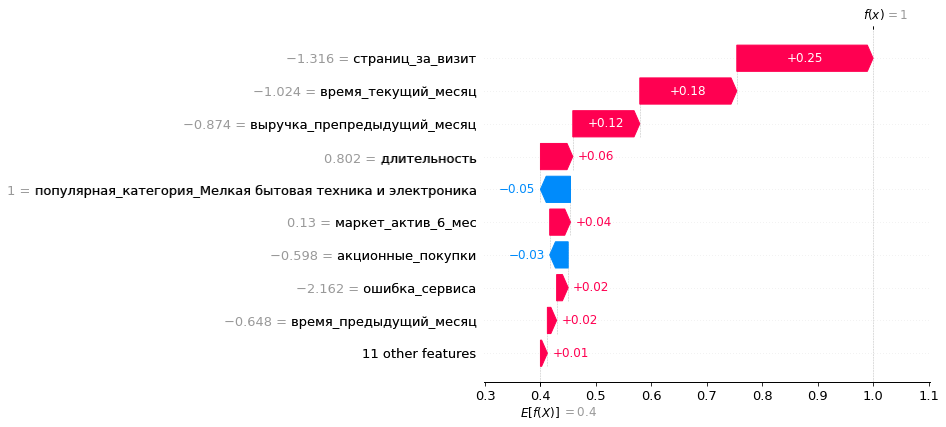

In [93]:
shap.plots.waterfall(shap_values[96]) 

Здесь можем наблюдать, что из-за низкого значения страниц за визит модель перетянула объект к классу 1.

### Вывод
Эти наблюдения можно использовать следующим образом:

Можно расширить датасет в будущем, использовав больше признаков, связанных с акциями или маркетинговыми активностями. 

Также увидели, что высокие значения неоплаченных продуктов в корзине ведут к большому риску снижения покупательской активности - можно подготовить более персонализированные предложения с акцией, для того, чтобы склонить покупателя к покупке. Здесь предполагаю, что покупатели кладут в корзину необходимые продукты и ждут определенных акций/предложений на них, но так как этот момент не наступает, они перестают пользоваться сайтом для покупок. 


## Сегментация покупателей

Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.

Выберите группу покупателей и предложите, как увеличить её покупательскую активность: 
Проведите графическое и аналитическое исследование группы покупателей.
Сделайте предложения по работе с сегментом для увеличения покупательской активности.

Сделайте выводы о сегментах:
какой сегмент вы взяли для дополнительного исследования,
какие предложения вы сделали и почему.

Ниже несколько примеров сегментов, но вы также можете выделить свой:  
- Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.
- Группа клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом.
- Группа клиентов, которые покупают товары из категории «Товары для себя» (новая категория, которую можно выделить на основе текущих) или «Товары для детей».
- Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

### Сегментация

In [94]:
#создадим функцию для подбора порога
def threshold_track(thresholds, df):
    data_fin = pd.DataFrame(columns=['порог', 'roc_auc', 'true_positive', 'false_positive', 'false_negative'])
    for i in thresholds:
        df['y_pred_'+str(i)] = df['y_proba'].apply(lambda x:0 if x < i else 1)
        roc_auc = roc_auc_score(df['y_valid'], df['y_pred_'+str(i)])
        fp = df[(df['y_pred_'+str(i)] == 1) & (df['y_valid'] == 0)].shape[0]
        fn = df[(df['y_pred_'+str(i)] == 0) & (df['y_valid'] == 1)].shape[0]
        tp = df[(df['y_pred_'+str(i)] == 1) & (df['y_valid'] == 1)].shape[0]
        data_fin = data_fin.append({
            'порог': 'y_pred_'+str(i),
            'roc_auc': roc_auc,
            'true_positive': tp,
            'false_positive': fp,
            'false_negative': fn
        }, ignore_index=True)
    return data_fin

In [95]:
#отложим данные с предсказаниями модели
y_proba = randomized_search.best_estimator_['models'].predict_proba(X_train_coded)[:,1]

In [96]:
#объединим истинные значения целевого признака и предсказания модели
data = pd.DataFrame(
    zip(y_train, y_proba), 
    columns = ['y_valid', 'y_proba']
).sort_values(by='y_proba',ascending=False)

data.head(10)

,y_valid,y_proba
569,1,0.997212
822,1,0.996955
102,1,0.996884
571,1,0.996502
737,1,0.996071
323,1,0.996012
640,1,0.995942
110,1,0.995760
566,1,0.995328
574,1,0.995012


In [97]:
#подготовим значения порогов
thresholds = [round(i,2) for i in np.linspace(0.65, 0.9, num = 20, endpoint=False)]

In [98]:
#произведем подбор
threshold_track(thresholds, data)

,порог,roc_auc,true_positive,false_positive,false_negative
0,y_pred_0.65,0.859172,277,17,94
1,y_pred_0.66,0.860004,277,16,94
2,y_pred_0.68,0.860637,275,12,96
3,y_pred_0.69,0.862300,275,10,96
4,y_pred_0.7,0.862300,275,10,96
5,y_pred_0.71,0.858574,271,8,100
6,y_pred_0.73,0.854530,268,8,103
7,y_pred_0.74,0.850487,265,8,106
8,y_pred_0.75,0.851319,265,7,106
9,y_pred_0.76,0.849456,263,6,108


Для сегментации возьмем подборку покупателей с высокой вероятностью снижения активности и высокой прибыльностью. 
Видим, что при пороге выше 0.74 падает значение roc-auc, а также сокращается количество правильно предсказанных объектов класса 1 и растет количество ложноотрицательных ответов - нам необходимо отобрать как можно больше покупателей с вероятностью снижения активности, поэтому выбираем этот порог. 

In [100]:
#закодируем признаки во всем датафрейме
X_coded = randomized_search.best_estimator_['preprocessor'].transform(X)
#создадим метки объектов с вероятностью выше выбранного порога 
y_proba_full = randomized_search.best_estimator_['models'].predict_proba(X_coded)[:,1]

In [101]:
#создадим метки объектов с вероятностью выше выбранного порога 
prediction_flags = np.where(y_proba_full > 0.74, True, False)

In [102]:
#создадим датасет со списком покупателей с высокой вероятностью снижения покупательской активности 
data_decline = X.loc[prediction_flags]
data_decline.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц
id,,,,,,,,,,,,,,,,
215349,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215351,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
215354,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,5685.0,4503.0,5869.6,11,12


In [103]:
#объединим данные со значениями прибыльности 
data_money_decline = data_decline.join(money_data, on='id')
data_money_decline.head(10)

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц,прибыль
id,,,,,,,,,,,,,,,,,
215349,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,4.16
215351,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,4.87
215352,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,4.21
215353,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,3.95
215354,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,5685.0,4503.0,5869.6,11,12,3.62
215356,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4146.5,4433.0,4566.4,6,7,4.93
215362,премиум,да,4.2,4,438,0.74,Домашний текстиль,3,4,6,4,4314.0,4765.0,4447.9,13,13,3.49
215363,стандарт,нет,4.9,4,923,0.29,Товары для детей,6,0,3,1,6010.0,4633.0,6128.3,8,5,1.83
215364,премиум,да,4.3,4,708,0.98,Домашний текстиль,3,3,3,3,5795.5,4942.0,5484.8,11,9,2.67


In [104]:
#выведем обзор данных
data_money_decline.describe()

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц,прибыль
count,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000
mean,3.500536,4.013405,633.766756,0.505845,2.477212,4.077748,3.758713,4.120643,4987.538874,4595.882038,5328.104021,9.659517,9.908847,3.995308
std,1.000779,0.708878,229.678040,0.307090,1.115695,2.314485,1.883919,1.753316,828.527423,226.457400,918.458745,2.346216,2.407929,0.989927
min,0.900000,3.000000,135.000000,0.120000,1.000000,0.000000,0.000000,1.000000,2890.000000,4098.000000,2758.700000,5.000000,4.000000,1.060000
25%,3.000000,4.000000,460.000000,0.280000,2.000000,2.000000,2.000000,3.000000,4450.000000,4435.000000,4651.700000,8.000000,8.000000,3.330000
50%,3.600000,4.000000,658.000000,0.350000,2.000000,4.000000,3.000000,4.000000,5096.500000,4607.000000,5342.100000,10.000000,10.000000,4.060000
75%,4.100000,5.000000,811.000000,0.900000,3.000000,6.000000,5.000000,5.000000,5581.000000,4756.000000,6061.400000,11.000000,12.000000,4.640000
max,5.600000,5.000000,1076.000000,0.990000,6.000000,10.000000,8.000000,9.000000,6809.000000,5124.000000,7799.400000,17.000000,17.000000,7.430000


Так как необходимо отобрать покупателей с высокой прибыльностью, отберем все объекты с прибыльностью выше медианного значения

In [105]:
data_money_decline = data_money_decline.query('прибыль > 4.06')

### Анализ сегмента

In [106]:
#подготовим список для построения графика распределения количественных признаков
num_col = data_money_decline.select_dtypes(include='number').columns.tolist()

In [107]:
#подготовим подписи графиков
labels_num = ['Ср.месячное значение маркетинговых активностей за посл. 6 месяцев',
        'Количество маркетинговых активностей в текущем месяце', 
        'Дней с момента регистрации', 
        'Ср.месячная доля покупок по акции от общего числа покупок за посл. 6 месяцев',
        'Среднее количество категорий за визит в течение последнего месяца',
        'Количество неоплаченных продуктов', 
        'Число сбоев за визит',
        'Среднее кол-во страниц за один визит на сайт за последние 3 месяца',
        'Выручка за предыдущий месяц',
        'Выручка за препредыдущий месяц',
        'Выручка за текущий месяц',
        'Время в предыдущем месяце, минут',
        'Время в текущем месяце, минут',
        'Прибыль'
              
       ]

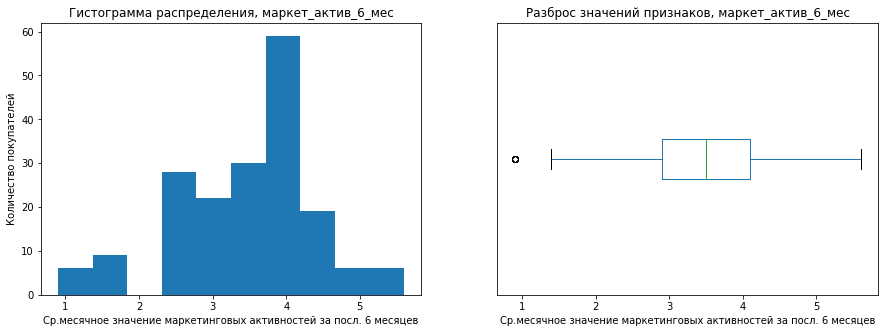

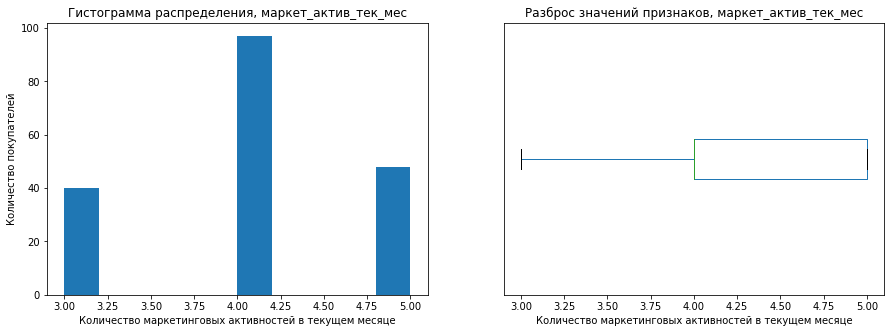

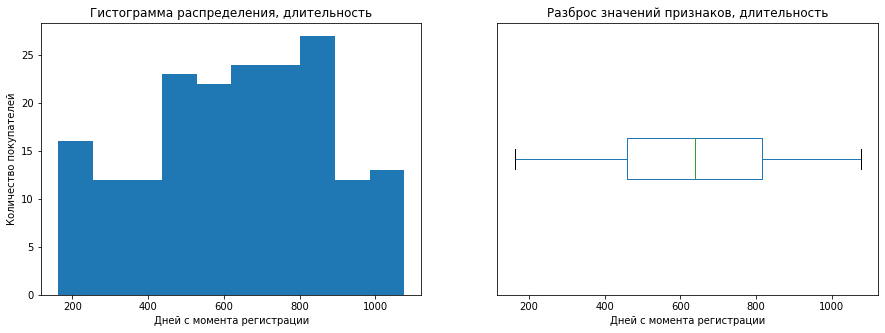

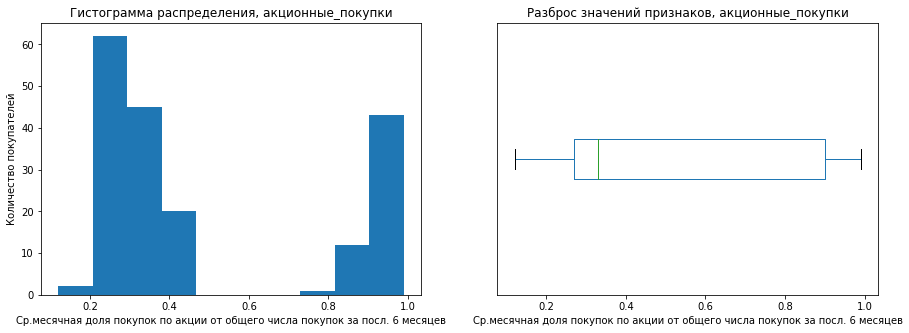

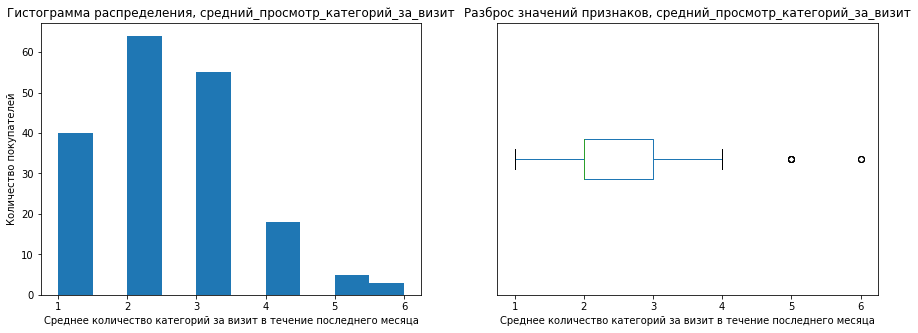

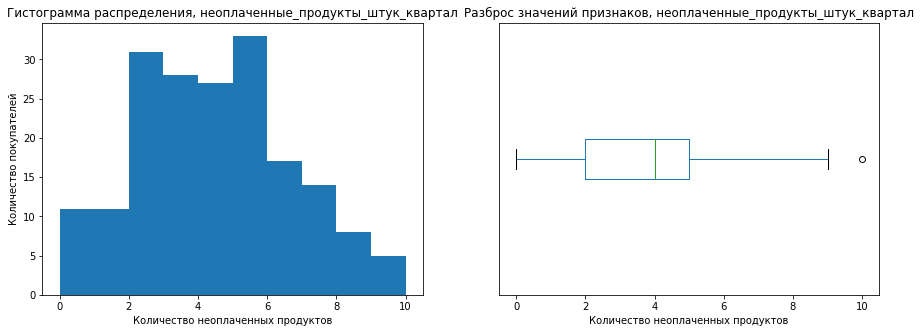

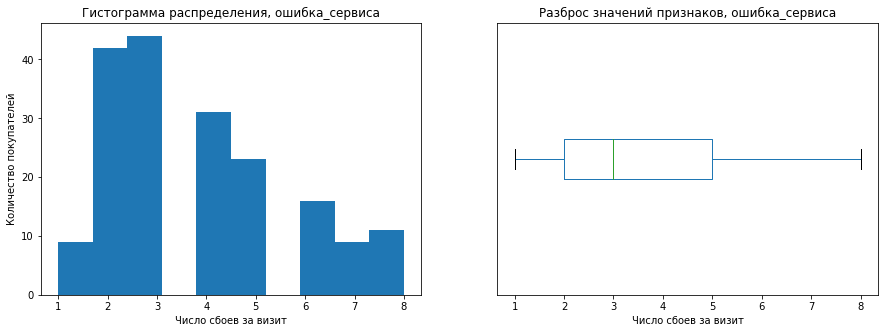

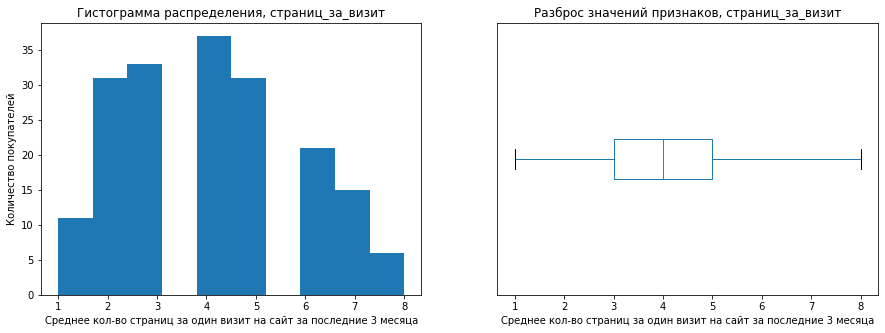

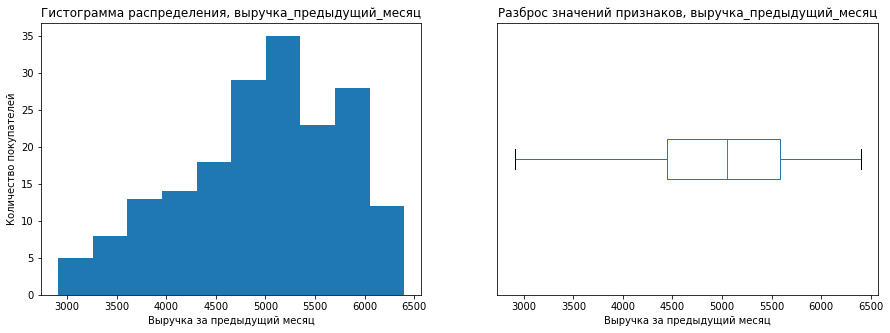

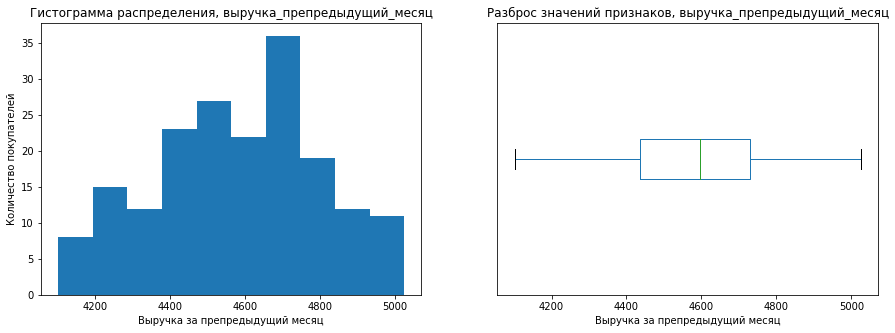

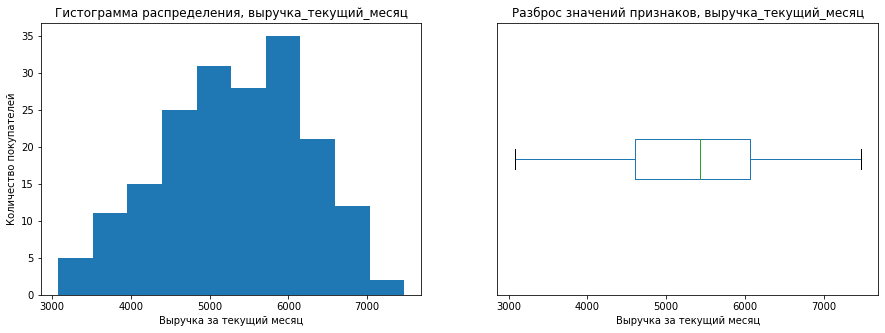

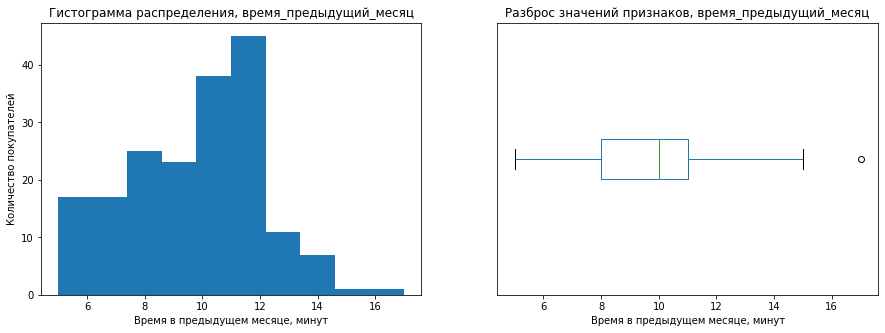

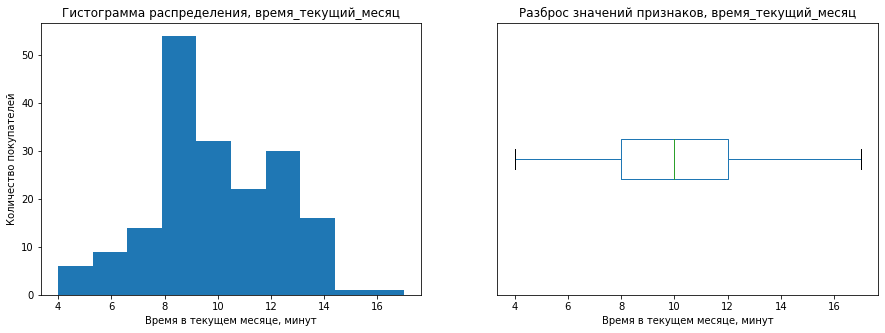

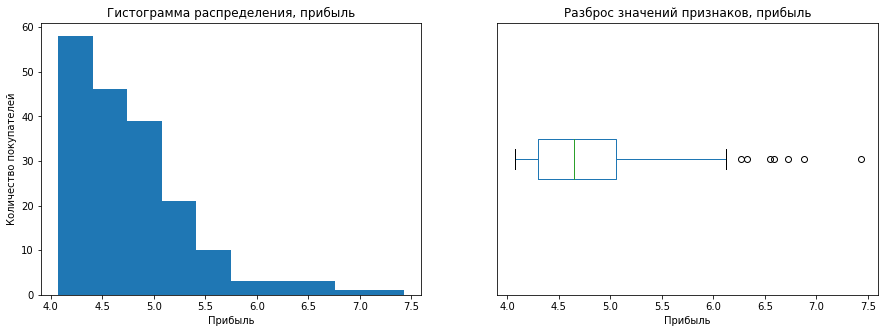

In [108]:
#построим график распределения признаков
graph_maker_num(data_money_decline, num_col, labels_num)

In [109]:
#подготовим список для построения графика распределения качественных признаков
cat_col = data_money_decline.select_dtypes(exclude='number').columns.tolist()

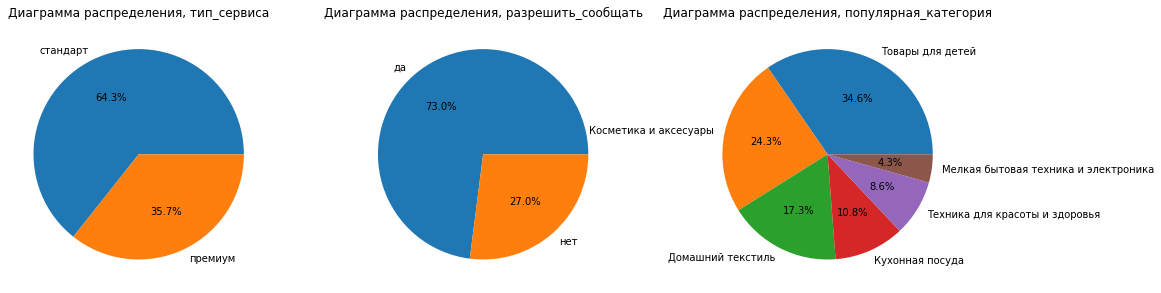

In [110]:
#построим графики распределения
cat_graph_maker(data_money_decline, cat_col)

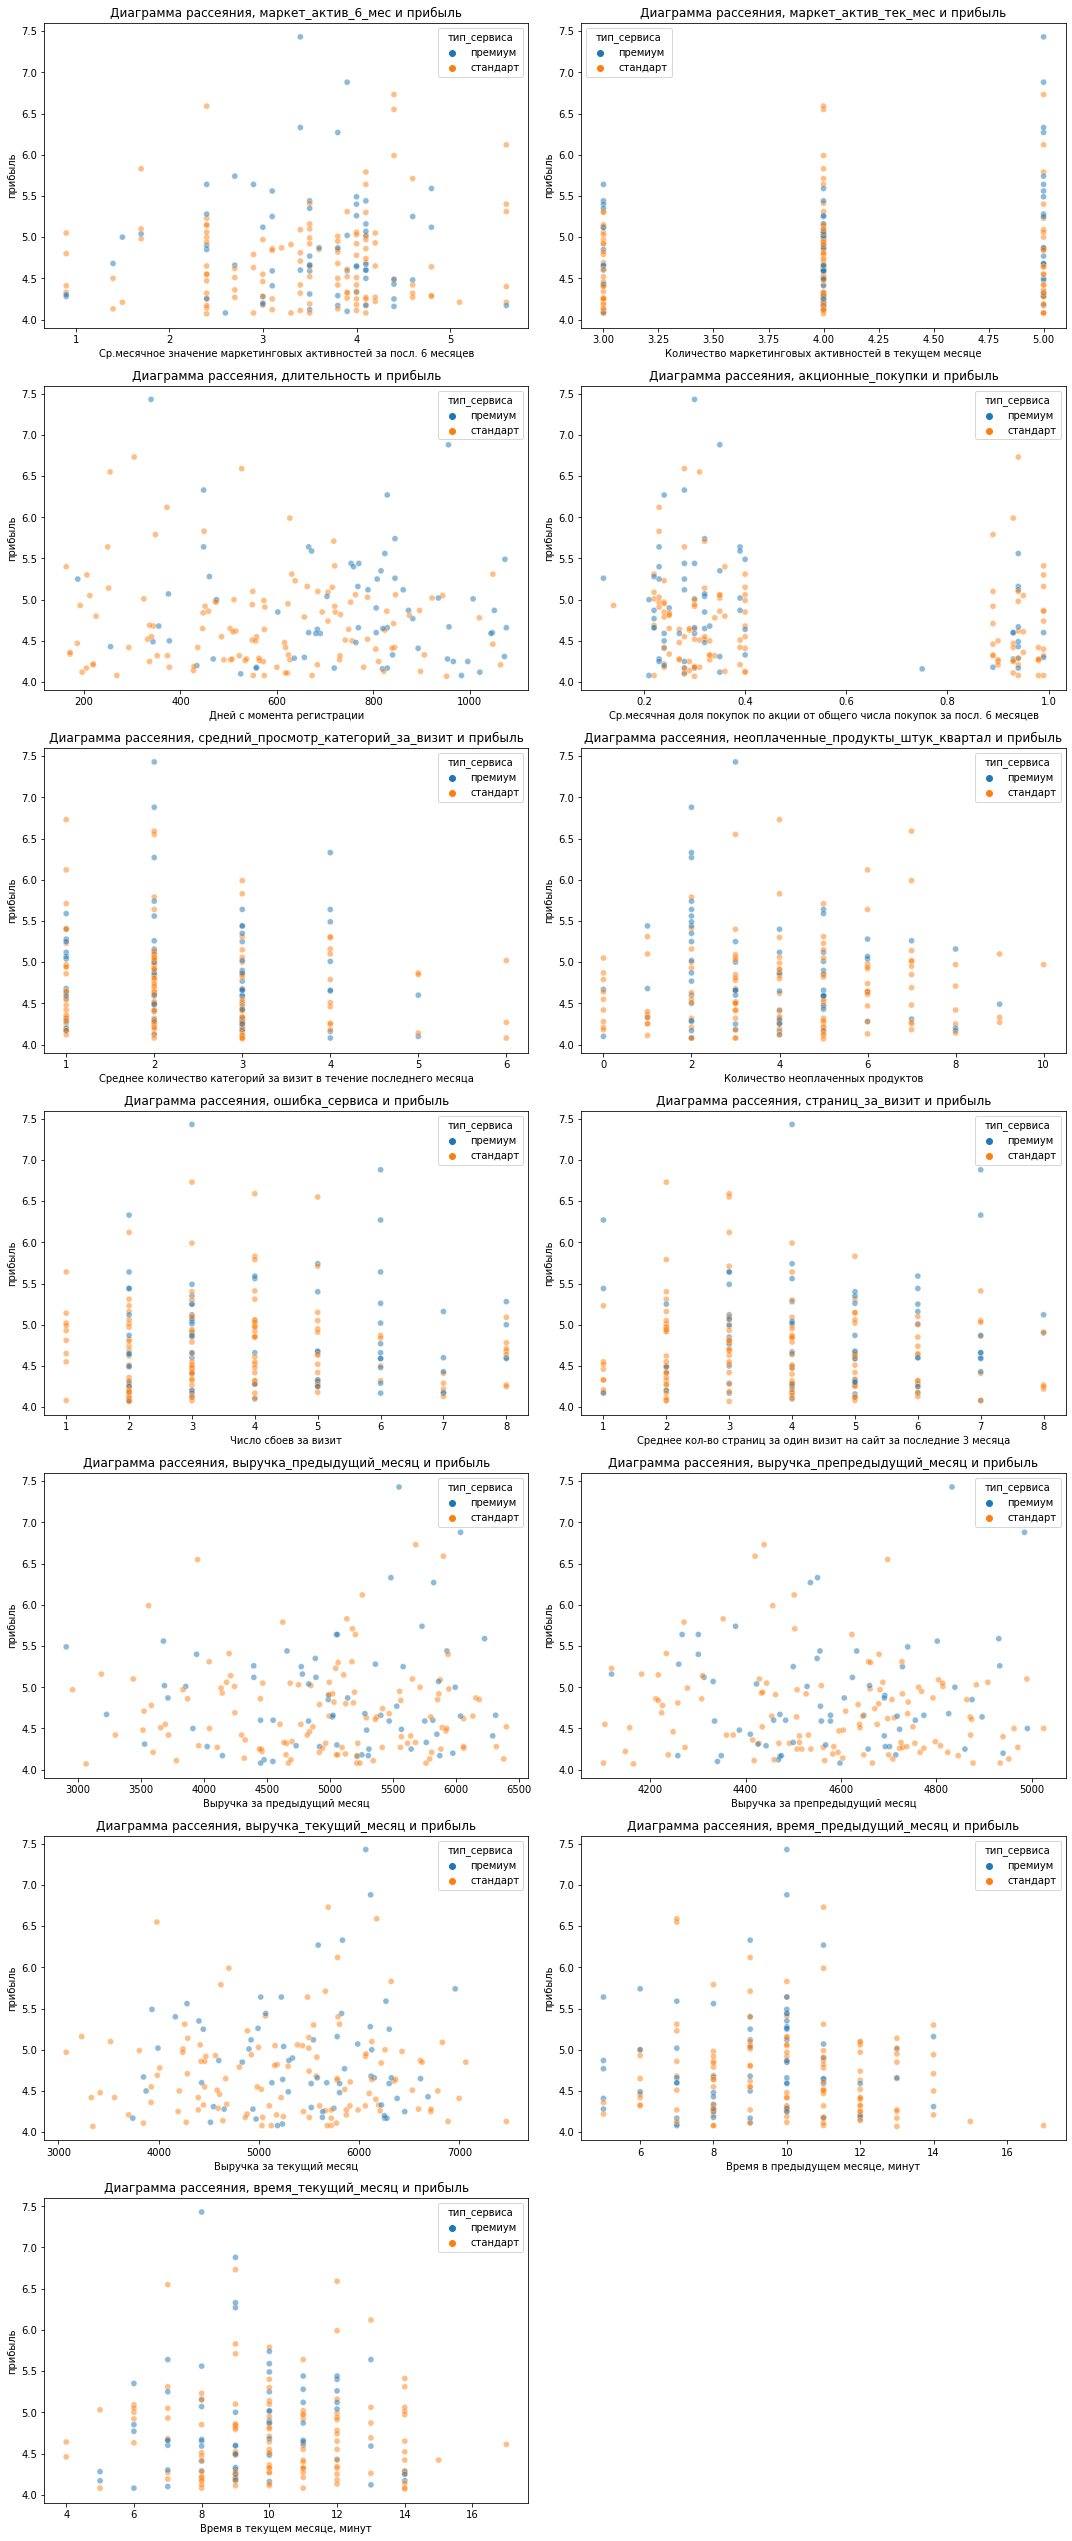

In [111]:
#построим диаграмму рассеяния с учетом значения типа сервиса
fig, ax = plt.subplots(figsize=(15,40))
for i, col_name in enumerate(num_col[:13], 1):
    ax = plt.subplot(8, 2, i)
    sns.scatterplot(data=data_money_decline, x=col_name, y='прибыль', hue='тип_сервиса', alpha=0.5, ax=ax)
    ax.set_title(f'Диаграмма рассеяния, {col_name} и прибыль')
    ax.set_xlabel(f'{labels_num[i-1]}')
    ax.set_ylabel('прибыль')
fig.tight_layout()  
plt.show() 


По графикам можно сделать выводы:
- маркетинговые активности в среднем составляют до 4х раз в месяц
- длительность регистрации составляет от 200 до 1100 дней
- за визит покупатели рассматривают 2-3 категории
- неоплаченные продукты - 2-5 шт в среднем
- медианные значения выручки и времени за последние 3 месяца остаются примерно постоянными
- есть два типа покупателей - с долей акционных покупок 10-50% и 75-100%
- самые популярные категории - товары для детей, косметика и аксессуары и домашний текстиль 
- техника не пользуется популярностью
- 27.4% от выборки не дает разрешение на сообщения о предложениях
- разделение по типу сервиса 63.7% к 36.3% (стандарт к премиуму)
- большая часть покупателей с типом сервиса премиум - зарегистрированы более, чем 400-600 дней назад и совершают меньше покупок по акции, с 2-5 неоплаченными товарами в корзинах, но проводят мало времени на сайте


### Вывод
Был выбран сегмент с высокой вероятностью снижения покупательской активности и высокой прибыльностью. 
Предложения для увеличения покупательской активности:
- так как большая доля акционных покупок сопуствует большому риску снижения активности, предполагаю, что нужно уменьшить маркетинговые активности подобного типа (например, не предлагать акции, но создать систему лояльности для покупателей)
- для акций можно предложить делать более персонализированные предложения - в особенности для категорий товаров для детей, домашнего текстиля и косметики
- также есть закономерность, что покупатели с типом сервиса премиум совершают меньше покупок по акции и не оставляют много товаров неоплаченными в корзине, но тем не менее проводят мало времени на сайте - необходимо сконцентрировать внимание на этой группе покупателей, разработать предложения или рекомендации.
- для покупателей с типом сервиса стандарт - например, изменить систему и переводить на статус премиум раньше, чем предположительно через 400 дней от регистрации (или создать другую систему лояльности). 

## Общий вывод

Была поставлена задача разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

1. Исходные данные были даны в виде четырех таблиц с данными по клиентам по следующим группам: 
- Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
- Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
- Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
- Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.

Была произведена предобработка данных, исправлены ошибки в написании наименовании столбцов, приведены к единому регистру. Не были найдены пропуски или дубликаты данных, типы данных соответствуют ожидаемым. 

2. Далее был произведен исследовательский анализ данных. Распределения признаков в целом нормальные.
Отметили небольшой дисбаланс признаков - покупательская активность (преобладает класс с прежним уровнем активности), тип сервиса (преобладает класс с сервисом стандарт) и разрешение на сообщения о дополнительных предложениях (преобладает класс, разрешающий сообщения)
Были отобраны клиенты с покупательской активностью не менее трех месяцев.

3. Далее таблицы были объединены в одну 

4. Произвели корреляционный анализ признаков. 
Отметили наличие высокой связи между признаками выручки в разные периоды, между длительностью регистрации покупателя и количеством неоплаченных продуктов, средним просмотром категорий и популярными категориями.

Высокая связь между покупательской активностью и средним количеством страниц за визит.

Заметная связь между длительностью и ошибками сервиса, просмотром страниц за визит, маркетинговой активностью за полгода, разрешением сообщать об предложениях и типом сервиса.

Заметная связь между покупательской активностью и временем в текущем и предыдущем месяцах, средним просмотром категорий, акционными покупками и маркетинговой активностью за полгода.

При этом можно отметить очень слабую связь или ее практически отсутствие между целевым признаком покупательской активности и длительностью регистрации, маркетинговыми активностями в текущем месяце, разрешением на оповещения с предложениями, выручкой в последние два месяца, ошибками сервиса, популярной категорией товаров.

Между признаками нет мультиколлинеарности.

5. Для поиска лучшей модели был использован общий пайплайн с подбором гиперпараметров

Были обучены четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). Для каждой подобраны гиперпараметры. Так как при анализе данных заметили небольшой дисбаланс классов, использовали метрику ROC-AUC для оценки качества модели.

Получили лучшую модель - SVC со со значением метрики ROC-AUC на тренировочной и тестовой выборке 0.91 и 0.89 соответственно.

6. Оценили важность признаков для лучшей модели и построили график важности с помощью метода SHAP.

Пришли к выводам: 
Чем больше времени провел покупатель на сайте в текущем и предыдущем месяце, тем меньше вероятность отнесения покупателя к классу 1 (снижение покупательской активности)
Чем больше страниц покупатель просматривает за визит, тем меньше вероятность отнесения покупателя к классу 1
Чем больше среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев, тем меньше вероятность отнесения покупателя к классу 1
Чем больше значение среднемесячной доли покупок по акции от общего числа покупок за последние 6 месяцев, тем выше риск снижения покупательской активности.
Чем больше число неоплаченных товаров за последние три месяца, тем выше риск снижения покупательской активности.

7. Был выбран сегмент с высокой вероятностью снижения покупательской активности и высокой прибыльностью. 

Предложения для увеличения покупательской активности:

- так как большая доля акционных покупок сопуствует большому риску снижения активности, предполагаю, что нужно уменьшить маркетинговые активности подобного типа (например, не предлагать акции, но создать систему лояльности для покупателей)
- для акций можно предложить делать более персонализированные предложения - в особенности для категорий товаров для детей, домашнего текстиля и косметики
- также есть закономерность, что покупатели с типом сервиса премиум совершают меньше покупок по акции и не оставляют много товаров неоплаченными в корзине, но тем не менее проводят мало времени на сайте - необходимо сконцентрировать внимание на этой группе покупателей, разработать предложения или рекомендации.
- для покупателей с типом сервиса стандарт - например, изменить систему и переводить на статус премиум раньше, чем предположительно через 400 дней от регистрации (или создать другую систему лояльности).